In [1]:
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import SGDClassifier

# If you set the display.max_colwidth option, the information will be displayed fully
pd.set_option('display.max_colwidth', None)

In [2]:
def tfidf_features(X_train, X_test, vectorizer_path):
    """Performs TF-IDF transformation and dumps the model."""
    
    # Train a vectorizer on X_train data.
    # Transform X_train and X_test data.
    
    # Pickle the trained vectorizer to 'vectorizer_path'
    # Don't forget to open the file in writing bytes mode.
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1, 2), token_pattern='(\S+)')
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    with open(vectorizer_path, 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)
        
    return X_train, X_test

In [3]:
# read cleaned data after prepared text
df = pd.read_csv('dialect_dataset_cleaned.csv')
print(f"the dataframe shape: {df.shape}")
df.head()

the dataframe shape: (458197, 3)


,id,dialect,text
0,1175358310087892992,IQ,بالنهايه ينتفض يغير
1,1175416117793349632,IQ,يعني محسوب البشر حيونه ووحشيه وتطلبون الغرب يحترمكم ويءمن بدينكم ولاينعتكم بالارهاب
2,1175450108898565888,IQ,مبين كلامه خليجي
3,1175471073770573824,IQ,يسلملي مرورك وروحك الحلوه
4,1175496913145217024,IQ,وين الغيبه اخ محمد


Number of dialect classes: 18


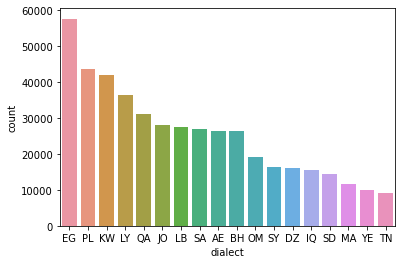

In [4]:
counts = df.dialect.value_counts()
print(f"Number of dialect classes: {df.dialect.nunique()}")
counts_df = pd.DataFrame(counts.to_dict().items(), columns=["dialect", "count"])
sns.barplot(data = counts_df, x="dialect", y="count", order=counts_df['dialect']);

In [5]:
X = df["text"].values.astype('U') # You need to convert the dtype object to unicode for using tfidf_vectorizer
y = df["dialect"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify= y) ######### YOUR CODE HERE ##########
print('Train size = {}, test size = {}'.format(len(X_train), len(X_test)))

X_train_tfidf, X_test_tfidf = tfidf_features(X_train, X_test, "Models/tfidf_vectorizer.pkl")

Train size = 412377, test size = 45820


In [6]:
(unique, counts) = np.unique(y_train, return_counts=True)
cw_dict = dict(zip(unique, np.around(1/counts *counts.max(),3)))
class_weight = cw_dict
print(class_weight)

{'AE': 2.192, 'BH': 2.192, 'DZ': 3.561, 'EG': 1.0, 'IQ': 3.719, 'JO': 2.064, 'KW': 1.369, 'LB': 2.087, 'LY': 1.579, 'MA': 4.995, 'OM': 3.015, 'PL': 1.318, 'QA': 1.855, 'SA': 2.148, 'SD': 3.993, 'SY': 3.549, 'TN': 6.233, 'YE': 5.806}


In [7]:
def plot_saveResults(model, modelname, X_train_tfidf, X_test_tfidf, y_train, y_test):
    print(f"-------------------------- [{modelname}] --------------------------")
    # check train accuracy
    y_train_pred = model.predict(X_train_tfidf)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print('Train accuracy = {}'.format(train_accuracy))

    # Check test accuracy.
    y_test_pred = model.predict(X_test_tfidf)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print('Test accuracy = {}'.format(test_accuracy))

    ## Show results
    list_names = list(model.classes_)
    print(classification_report(y_test, y_test_pred, target_names=list_names))
    
    fig, ax = plt.subplots(1,2,figsize= (30,15))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred ,normalize ='true' ), display_labels=list_names).plot(ax=ax[0]);
    ax[0].set_title(f"[{modelname}] Test Confusion Matrix\nf1_score: {f1_score(y_test, y_test_pred, average='micro')}",font ={'weight' : 'bold'})
    ax[0].set_xlabel('Predictions dialect',font ={'weight' : 'bold'})
    ax[0].set_ylabel('Actual dialect',font ={'weight' : 'bold'})

    ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred ,normalize ='true' ), display_labels=list_names).plot(ax=ax[1]);
    ax[1].set_title(f"[{modelname}]Train Confusion Matrix\nf1_score: {f1_score(y_train, y_train_pred, average='micro')}",font ={'weight' : 'bold'})
    ax[1].set_xlabel('Predictions dialect',font ={'weight' : 'bold'})
    ax[1].set_ylabel('Actual dialect',font ={'weight' : 'bold'})
    plt.savefig("Models/"+modelname+'_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    with open("Models/"+ modelname + ".pkl", 'wb') as f:
        pickle.dump(model, f)

-------------------------- [LogisticReg] --------------------------
Train accuracy = 0.7415859759394923
Test accuracy = 0.5298123090353557
              precision    recall  f1-score   support

          AE       0.42      0.44      0.43      2630
          BH       0.37      0.34      0.36      2629
          DZ       0.51      0.54      0.52      1618
          EG       0.76      0.79      0.78      5764
          IQ       0.53      0.57      0.55      1550
          JO       0.43      0.36      0.39      2792
          KW       0.55      0.52      0.54      4211
          LB       0.63      0.66      0.65      2762
          LY       0.69      0.65      0.67      3650
          MA       0.62      0.61      0.61      1154
          OM       0.34      0.40      0.36      1912
          PL       0.54      0.47      0.50      4374
          QA       0.50      0.46      0.48      3107
          SA       0.40      0.45      0.42      2683
          SD       0.59      0.61      0.60      1

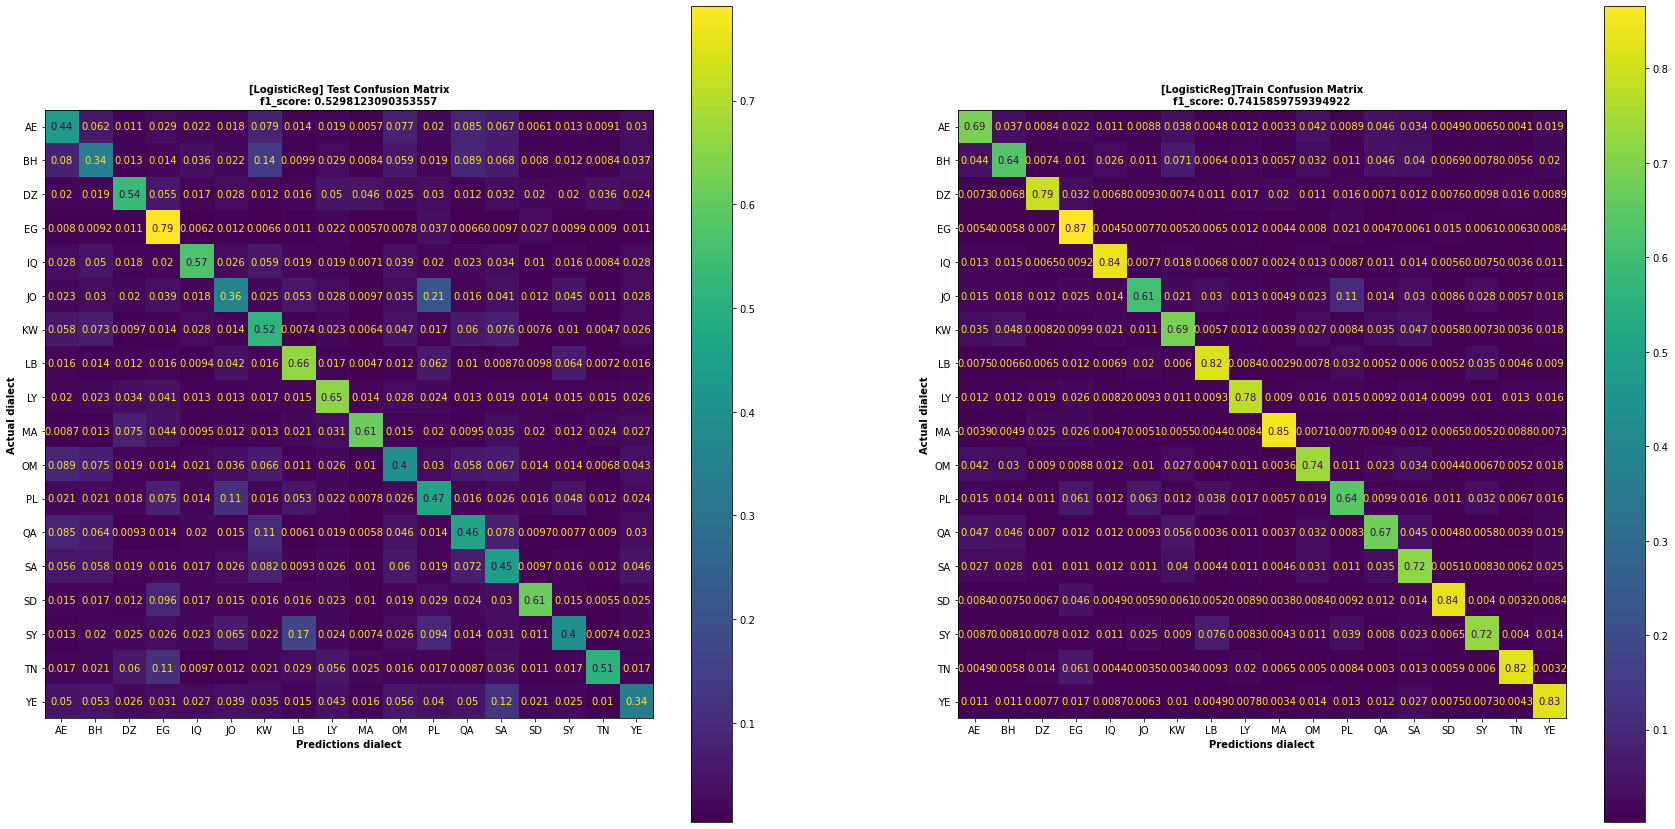

In [8]:
dialect_recognizer = LogisticRegression(penalty='l2', C=1, random_state=0, solver='liblinear', class_weight= class_weight)
dialect_recognizer.fit(X_train_tfidf, y_train)

plot_saveResults(dialect_recognizer, "LogisticReg", X_train_tfidf, X_test_tfidf, y_train, y_test)

-------------------------- [ComplementNaiveBayes] --------------------------
Train accuracy = 0.6681313458316055
Test accuracy = 0.5126800523788738
              precision    recall  f1-score   support

          AE       0.42      0.37      0.39      2630
          BH       0.38      0.28      0.32      2629
          DZ       0.54      0.48      0.51      1618
          EG       0.60      0.89      0.72      5764
          IQ       0.61      0.50      0.55      1550
          JO       0.44      0.23      0.30      2792
          KW       0.46      0.60      0.52      4211
          LB       0.53      0.71      0.61      2762
          LY       0.63      0.66      0.64      3650
          MA       0.64      0.58      0.61      1154
          OM       0.46      0.27      0.35      1912
          PL       0.47      0.52      0.50      4374
          QA       0.43      0.49      0.46      3107
          SA       0.40      0.38      0.39      2683
          SD       0.65      0.47      0.

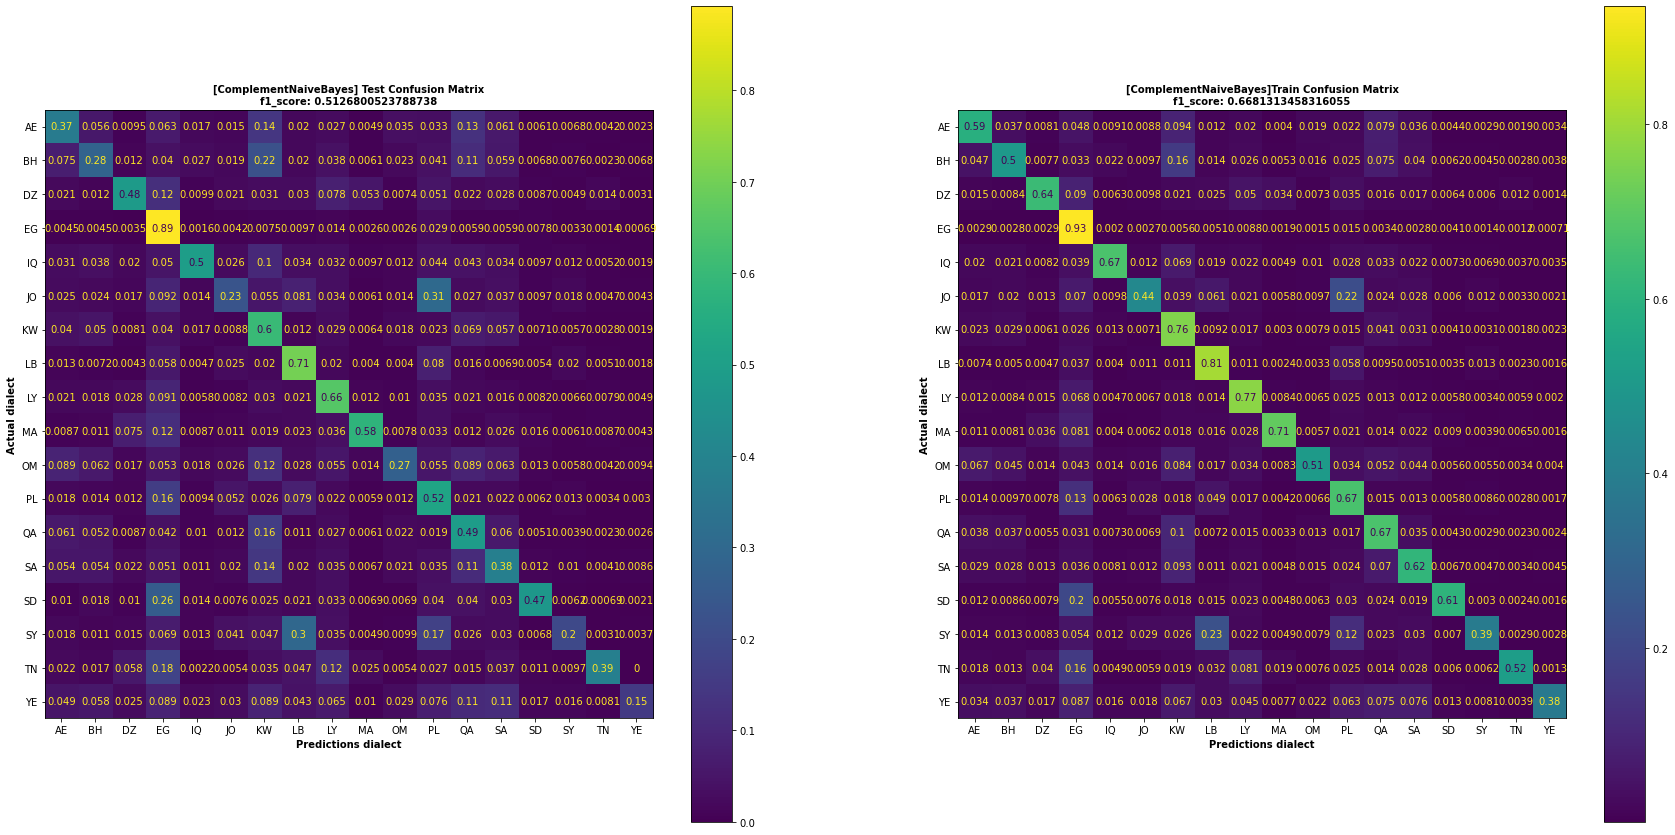

In [9]:
dialect_recognizer = ComplementNB()
dialect_recognizer.fit(X_train_tfidf, y_train)

plot_saveResults(dialect_recognizer, "ComplementNaiveBayes", X_train_tfidf, X_test_tfidf, y_train, y_test)

-------------------------- [SGDClassifier] --------------------------
Train accuracy = 0.6031713698872634
Test accuracy = 0.46606285464862507
              precision    recall  f1-score   support

          AE       0.46      0.36      0.40      2630
          BH       0.44      0.23      0.30      2629
          DZ       0.38      0.52      0.44      1618
          EG       0.63      0.81      0.71      5764
          IQ       0.32      0.63      0.42      1550
          JO       0.51      0.20      0.28      2792
          KW       0.58      0.41      0.48      4211
          LB       0.44      0.74      0.55      2762
          LY       0.64      0.56      0.60      3650
          MA       0.33      0.64      0.43      1154
          OM       0.36      0.34      0.35      1912
          PL       0.58      0.30      0.40      4374
          QA       0.49      0.39      0.43      3107
          SA       0.41      0.36      0.39      2683
          SD       0.35      0.59      0.44    

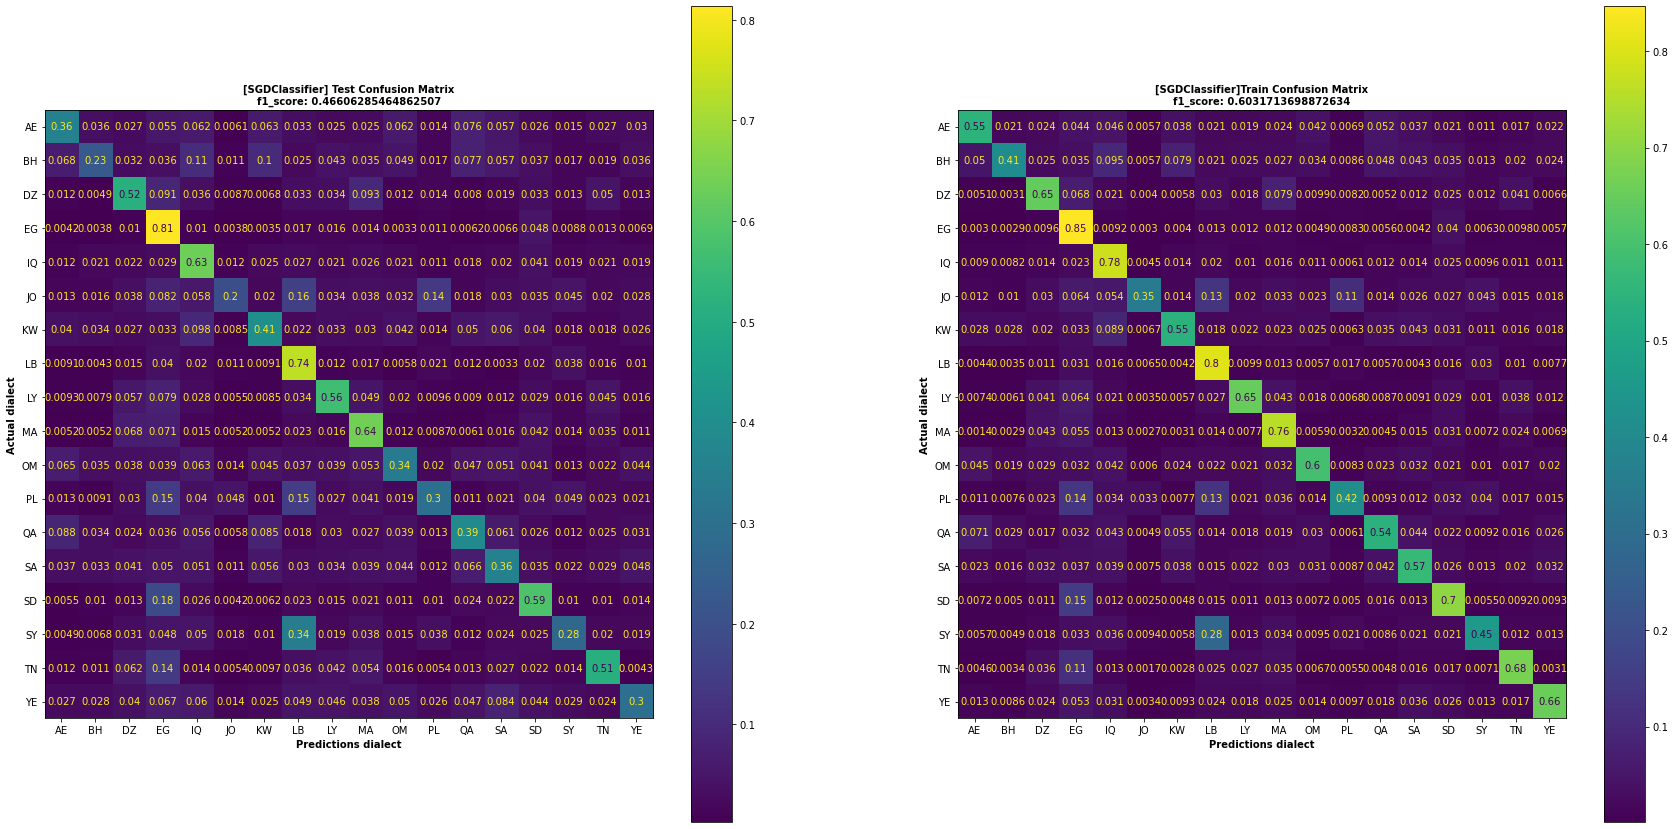

In [10]:
dialect_recognizer = SGDClassifier(loss='hinge', n_jobs=-1, class_weight= class_weight)
dialect_recognizer.fit(X_train_tfidf, y_train)

plot_saveResults(dialect_recognizer, "SGDClassifier", X_train_tfidf, X_test_tfidf, y_train, y_test)